# Instrumental variables (IV)

Instrumental variables (IV) refer to a method used in econometrics to estimate causal relationships when controlled experiments are not feasible and an explanatory variable is correlated with the error term, leading to **endogeneity issues**. Saying that a variable is correlated with the error term means that the variable and the error term share some common influence or that the variable captures some part of the variability in the dependent variable that should be attributed to the error term. When we say a variable is correlated with the error term, it means that both the variable and the error term are influenced by some common external factors. In other words, the variable captures some variability in the outcome that should be attributed to these external influences, which introduces bias in our estimates. This happens because the variable not only shows its direct effect on the outcome but also the effect of those omitted external factors.

## Endogeneity
Endogeneity can occur due to:
1. **Omitted variable bias**: unobserved variables that affect both the explanatory variable and the outcome.
2. **Simultaneity**: when the explanatory variable and the outcome influence each other
3. **Measurement error**: Inaccuracies in measuring the explanatory variable.

For instance, consider trying to understand how wind power production impacts wholesale electricity prices. However, if wind power production and prices are also affected by factors like solar power or broader economic trends, these external influences can bias our estimates. Here, we can use an IV, like wind speed forecasts, which affects wind power production but doesn’t directly influence electricity prices except through its effect on wind power. This helps us isolate the true effect of wind power production on prices, giving a clearer picture of the causal relationship.

An IV has two main properties:
1. **Relevance**: the IV needs to be something that is related to the variable you're interested in studying.
2. **Exogeneity**: the IV should not be influenced by other factors that affect the outcome you're studying.


Here is a representation of a case where a candidate IV (wind speed forecast) can help us isolate the effect of an explanatory variable (wind power production), on the response variable (price).

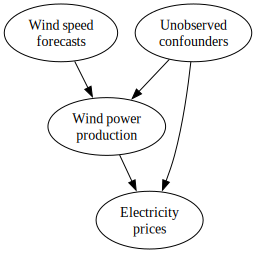

In [1]:
import graphviz
from IPython.display import display

# Create a new graph
dot = graphviz.Digraph()

# Add nodes
dot.node('Z', 'Wind speed\nforecasts')
dot.node('X', 'Wind power\nproduction')
dot.node('Y', 'Electricity \nprices')
dot.node('U', 'Unobserved\nconfounders')

# Add edges
dot.edge('Z', 'X')
dot.edge('X', 'Y')
dot.edge('U', 'X')
dot.edge('U', 'Y')

# Display the graph in the notebook
display(dot)


Let's now generate some data for this example

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulate data
n = 1000
true_effect = 2  # True causal effect of wind power production on electricity prices
wind_speed_forecasts = np.random.uniform(0, 10, n)  # IV
unobserved_confounders = np.random.normal(0, np.sqrt(10), n)  # Unobserved factors with variance 10
wind_power_production = 2 * wind_speed_forecasts + unobserved_confounders + np.random.normal(0, 1, n)
electricity_prices = true_effect * wind_power_production + 1.5 * unobserved_confounders + np.random.normal(0, 1, n)

# Create DataFrame
data = pd.DataFrame({
    'WindSpeedForecasts': wind_speed_forecasts,
    'WindPowerProduction': wind_power_production,
    'ElectricityPrices': electricity_prices
})

data.head()

,WindSpeedForecasts,WindPowerProduction,ElectricityPrices
0,3.745401,6.646425,15.010277
1,9.507143,14.708451,22.433042
2,7.319939,14.337450,29.275135
3,5.986585,14.664067,31.182353
4,1.560186,4.973025,12.114167


## Two-stage least squares (2SLS)



OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:      ElectricityPrices   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Fri, 24 May 2024   Prob (F-statistic):               0.00
Time:                        17:33:04   Log-Likelihood:                -2886.7
No. Observations:                1000   AIC:                             5777.
Df Residuals:                     998   BIC:                             5787.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const     

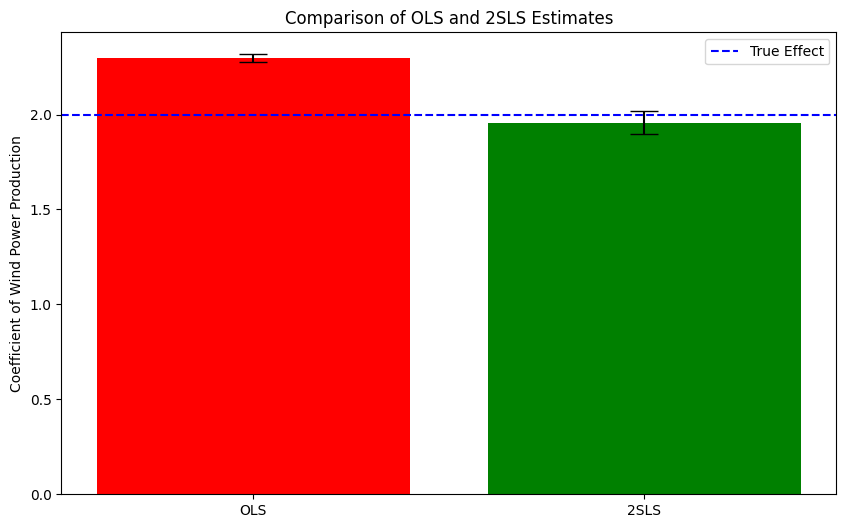

In [3]:


# Perform OLS regression
X_ols = sm.add_constant(data['WindPowerProduction'])
ols_model = sm.OLS(data['ElectricityPrices'], X_ols).fit()
print("OLS Regression Results:")
print(ols_model.summary())

# First stage of 2SLS: Regress WindPowerProduction on WindSpeedForecasts
X_first_stage = sm.add_constant(data['WindSpeedForecasts'])
first_stage_model = sm.OLS(data['WindPowerProduction'], X_first_stage).fit()
data['FittedWindPowerProduction'] = first_stage_model.fittedvalues

# Second stage of 2SLS: Regress ElectricityPrices on the fitted values from the first stage
X_second_stage = sm.add_constant(data['FittedWindPowerProduction'])
second_stage_model = sm.OLS(data['ElectricityPrices'], X_second_stage).fit()
print("\n2SLS Regression Results:")
print(second_stage_model.summary())

# Extract coefficients and standard errors
ols_coef = ols_model.params.iloc[1]
ols_se = ols_model.bse.iloc[1]

second_stage_coef = second_stage_model.params.iloc[1]
second_stage_se = second_stage_model.bse.iloc[1]

# Print the comparison
print(f"\nComparison of Coefficients and Standard Errors:")
print(f"OLS Coefficient: {ols_coef:.3f}, Standard Error: {ols_se:.3f}")
print(f"2SLS Coefficient: {second_stage_coef:.3f}, Standard Error: {second_stage_se:.3f}")

# Plot the comparison
labels = ['OLS', '2SLS']
coefficients = [ols_coef, second_stage_coef]
errors = [ols_se, second_stage_se]

plt.figure(figsize=(10, 6))
plt.bar(labels, coefficients, yerr=errors, capsize=10, color=['red', 'green'])
plt.axhline(y=true_effect, color='blue', linestyle='--', label='True Effect')
plt.ylabel('Coefficient of Wind Power Production')
plt.title('Comparison of OLS and 2SLS Estimates')
plt.legend()
plt.show()

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:      ElectricityPrices   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Fri, 24 May 2024   Prob (F-statistic):               0.00
Time:                        17:33:04   Log-Likelihood:                -2886.7
No. Observations:                1000   AIC:                             5777.
Df Residuals:                     998   BIC:                             5787.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const     

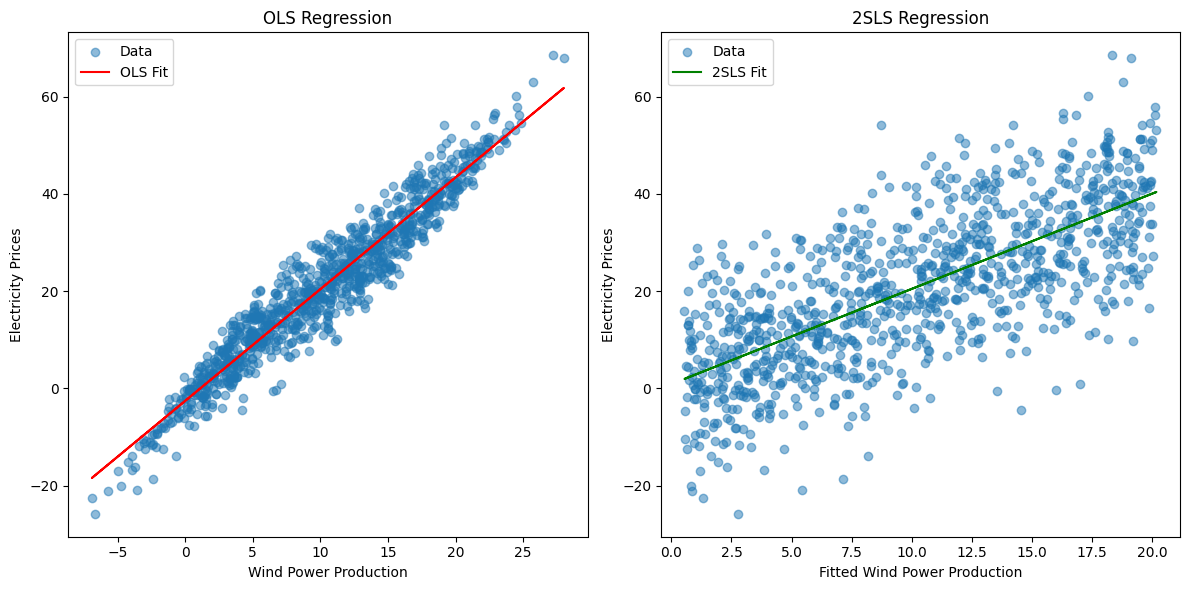

In [4]:
# Perform OLS regression
X_ols = sm.add_constant(data['WindPowerProduction'])
ols_model = sm.OLS(data['ElectricityPrices'], X_ols).fit()
print("OLS Regression Results:")
print(ols_model.summary())

# First stage of 2SLS: Regress WindPowerProduction on WindSpeedForecasts
X_first_stage = sm.add_constant(data['WindSpeedForecasts'])
first_stage_model = sm.OLS(data['WindPowerProduction'], X_first_stage).fit()
data['FittedWindPowerProduction'] = first_stage_model.fittedvalues

# Second stage of 2SLS: Regress ElectricityPrices on the fitted values from the first stage
X_second_stage = sm.add_constant(data['FittedWindPowerProduction'])
second_stage_model = sm.OLS(data['ElectricityPrices'], X_second_stage).fit()
print("\n2SLS Regression Results:")
print(second_stage_model.summary())

# Plot the results
plt.figure(figsize=(12, 6))

# OLS plot
plt.subplot(1, 2, 1)
plt.scatter(data['WindPowerProduction'], data['ElectricityPrices'], alpha=0.5, label='Data')
plt.plot(data['WindPowerProduction'], ols_model.fittedvalues, color='red', label='OLS Fit')
plt.xlabel('Wind Power Production')
plt.ylabel('Electricity Prices')
plt.title('OLS Regression')
plt.legend()

# 2SLS plot
plt.subplot(1, 2, 2)
plt.scatter(data['FittedWindPowerProduction'], data['ElectricityPrices'], alpha=0.5, label='Data')
plt.plot(data['FittedWindPowerProduction'], second_stage_model.fittedvalues, color='green', label='2SLS Fit')
plt.xlabel('Fitted Wind Power Production')
plt.ylabel('Electricity Prices')
plt.title('2SLS Regression')
plt.legend()

plt.tight_layout()
plt.show()




Formally, consider the following structural model:

\[
Y = \beta_0 + \beta_1 X + u
\]

where \( X \) is endogenous. We need an instrument \( Z \) such that:
1. \( \text{Cov}(Z, X) \neq 0 \)
2. \( \text{Cov}(Z, u) = 0 \)

The IV estimator involves two stages:
1. **First Stage**: Regress \( X \) on \( Z \) to get the predicted values of \( X \), denoted by \( \hat{X} \).
2. **Second Stage**: Regress \( Y \) on \( \hat{X} \) to obtain the IV estimate of \( \beta_1 \).

### Mathematical Formulation

1. **First Stage**:
   \[
   X = \pi_0 + \pi_1 Z + v
   \]
   Estimate \( \pi_0 \) and \( \pi_1 \) using OLS, and obtain \( \hat{X} = \pi_0 + \pi_1 Z \).

2. **Second Stage**:
   \[
   Y = \alpha_0 + \alpha_1 \hat{X} + \epsilon
   \]
   Estimate \( \alpha_0 \) and \( \alpha_1 \) using OLS. The coefficient \( \alpha_1 \) is the IV estimate of \( \beta_1 \).

## Example: IV in Electricity Markets

We aim to estimate the impact of high wind days on electricity prices, addressing potential endogeneity between wind and electricity prices. We use an instrumental variable that affects wind generation but not directly electricity prices.



In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Simulate data
np.random.seed(0)
n_samples = 1000
temperature = np.random.uniform(0, 40, n_samples)
demand = np.random.uniform(1000, 5000, n_samples)
wind_speed = np.random.uniform(0, 20, n_samples)
elevation = np.random.uniform(0, 1000, n_samples)

# Endogenous variable: wind generation
wind_generation = 5 * wind_speed + 0.1 * temperature + np.random.normal(0, 2, n_samples)

# Electricity price
price = 50 + 0.5 * temperature + 0.2 * demand - 0.1 * wind_generation + np.random.normal(0, 5, n_samples)

# Create DataFrame
data = pd.DataFrame({
    'Temperature': temperature,
    'Demand': demand,
    'WindSpeed': wind_speed,
    'Elevation': elevation,
    'WindGeneration': wind_generation,
    'Price': price
})

data.head()

,Temperature,Demand,WindSpeed,Elevation,WindGeneration,Price
0,21.952540,3371.521083,16.230369,413.962496,84.461038,726.818339
1,28.607575,1040.254783,9.521680,629.618303,46.996672,266.142911
2,24.110535,2903.304783,10.463120,778.584264,53.973084,633.621911
3,21.795327,3835.081564,5.010412,851.557794,25.413527,822.808563
4,16.946192,1175.901728,12.100860,816.412714,61.908580,292.288841


In [6]:
# First Stage: WindGeneration ~ Elevation + Temperature + Demand
first_stage = sm.OLS(data['WindGeneration'], sm.add_constant(data[['Elevation', 'Temperature', 'Demand']])).fit()
data['PredictedWindGeneration'] = first_stage.predict(sm.add_constant(data[['Elevation', 'Temperature', 'Demand']]))

# Second Stage: Price ~ PredictedWindGeneration + Temperature + Demand
second_stage = sm.OLS(data['Price'], sm.add_constant(data[['PredictedWindGeneration', 'Temperature', 'Demand']])).fit()

# Output the results
print("First Stage Results:\n", first_stage.summary())
print("\nSecond Stage Results:\n", second_stage.summary())

First Stage Results:
                             OLS Regression Results                            
Dep. Variable:         WindGeneration   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8096
Date:                Fri, 24 May 2024   Prob (F-statistic):              0.489
Time:                        17:33:04   Log-Likelihood:                -4773.3
No. Observations:                1000   AIC:                             9555.
Df Residuals:                     996   BIC:                             9574.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          48.5141      

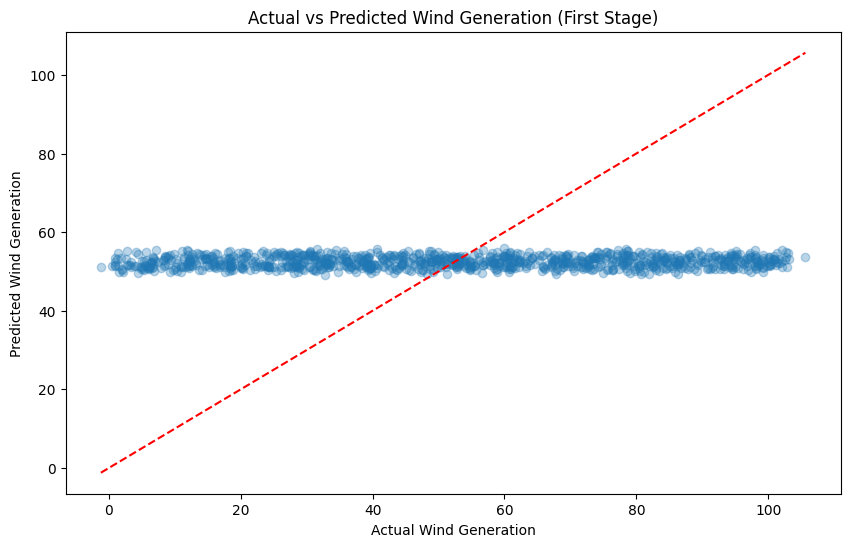

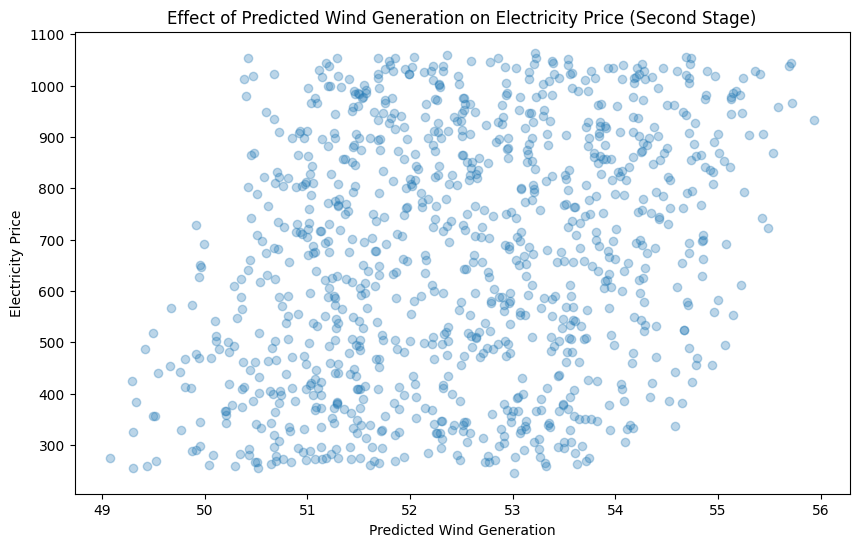

In [7]:
# Plot the actual vs predicted wind generation
plt.figure(figsize=(10, 6))
plt.scatter(data['WindGeneration'], data['PredictedWindGeneration'], alpha=0.3)
plt.plot([data['WindGeneration'].min(), data['WindGeneration'].max()], 
         [data['WindGeneration'].min(), data['WindGeneration'].max()], 'r--')
plt.xlabel('Actual Wind Generation')
plt.ylabel('Predicted Wind Generation')
plt.title('Actual vs Predicted Wind Generation (First Stage)')
plt.show()

# Plot the effect of predicted wind generation on price
plt.figure(figsize=(10, 6))
plt.scatter(data['PredictedWindGeneration'], data['Price'], alpha=0.3)
plt.xlabel('Predicted Wind Generation')
plt.ylabel('Electricity Price')
plt.title('Effect of Predicted Wind Generation on Electricity Price (Second Stage)')
plt.show()